# Transfer-Matrix Calculation For Multivalent Interactions

In this calculation, the ligand has two binding domains and the target has multiple binding sites that can be defined by users. The domain-site interaction energies and inter-domain cooperativity can be defined by userse also. The codes are separated to the first main section, which has the necessary functions to do transfer matrix calculation and followed four sections, which are corresponding to calculating four results in the main text.

To run the calculation, please follow the steps below.
1. Click 'Run cell' of the 'Initializtion' and 'Necessary functions' cells first.
2. Choose the sections of results that the user would like to know. Define the initial values needed, such as the number of target sites, the domain-site interaction energies, etc. The energy values are in unit $k_BT$.
3. Run all the cells in the chosen sections and get the results.



In [ ]:
#@title Initialization { display-mode: "both" }

import numpy as np
import matplotlib.pyplot as plt

vir_para = 0.001  # the auxiliary energy term parameter $\lambda$
U = np.array([1, 1, 1, 1, 1, 0, 0])  # boundary condition of first site, vector U


In [ ]:
#@title Necessary functions
def lnZ_array_func(right_vec, matrix_array, small_num, cal_site, state, N):
    matrix_mul = np.identity(7)
    max_val = np.zeros(N - 1)
    for i in range(N - 1):
        matrix = matrix_array[i].copy()
        if i == cal_site:
            matrix[state] = matrix[state] * np.exp(small_num)
            matrix_mul = matrix_mul @ matrix
        else:
            matrix_mul = matrix_mul @ matrix
        max_val[i] = matrix_mul.max()
        matrix_mul = matrix_mul / max_val[i]
    lnZ = np.log(U @ matrix_mul @ right_vec) + np.sum(np.log(max_val))
    return lnZ

def e_func(a,b,ab,ba,c_ab,N):
    e_a = np.zeros((N, len(c_ab)))
    e_b = np.zeros((N, len(c_ab)))
    e_ab = np.zeros((N-1, len(c_ab)))
    e_ba = np.zeros((N-1, len(c_ab)))
    for i in range(N):
        e_a[i] = np.exp(a[i]) * c_ab  # exp(-\beta\epsilon^A)
        e_b[i] = np.exp(b[i]) * c_ab  # exp(-\beta\epsilon^B)
    for i in range(N-1):
        e_ab[i] = np.exp(a[i] + b[i+1] + ab) * c_ab  # exp(-\beta\epsilon^AB)
        e_ba[i] = np.exp(a[i+1] + b[i] + ba) * c_ab  # exp(-\beta\epsilon^BA)
    return e_a,e_b,e_ab,e_ba

def p_cal_state(a,b,ab,ba,c_ab,state,N):
    if N > 1:
        T_array = np.zeros((N-1,7,7))  # initialization of transfer matrix array
    elif N == 1:
        T_array = [np.identity(7)]
    p = np.zeros((N, len(c_ab)))  # initialization of the probability of every site on the calculating state when ligands have A and B domains
    [e_A,e_B,e_AB,e_BA] = e_func(a,b,ab,ba,c_ab,N)
    for m in range(len(c_ab)):
        Y = np.array([1, e_A[-1][m], e_B[-1][m], 0, 0, 1, 1])  # boundary condition of last site, vector Y
        for n in range(N-1):
            T_array[n] = np.array([[1, 1, 1, 1, 1, 0, 0], [e_A[n][m], e_A[n][m], e_A[n][m], e_A[n][m], e_A[n][m], 0, 0],
                      [e_B[n][m], e_B[n][m], e_B[n][m], e_B[n][m], e_B[n][m], 0, 0], [0, 0, 0, 0, 0, e_AB[n][m], 0],
                      [0, 0, 0, 0, 0, 0, e_BA[n][m]], [1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 0, 0]])
        lnZ = lnZ_array_func(Y, T_array, 0, 0, state, N)
        for j in range(N):
            if j == N-1:
                Y1 = np.array([1, e_A[-1][m], e_B[-1][m], 0, 0, 1, 1])  # boundary condition of last site, vector Y
                Y1[state] = Y1[state] * np.exp(vir_para)
                lnZ1 = lnZ_array_func(Y1, T_array, 0, 0, state, N)
            else:
                lnZ1 = lnZ_array_func(Y, T_array, vir_para, j, state, N)
            p[j][m] = (lnZ1 - lnZ) / vir_para
    return p

def mul_list(myList):
    result = 1
    for x in myList:
         result = result * x
    return result

def single_mul_list(energy_list):
    result = 1
    for x in energy_list:
        result = result * 1 / (1 + x)
    return result


# The probabilities of unbound, single-domain bound and two-domain bound

In [ ]:
#@title Set values
#@markdown Set number of target sites
num_of_site = 3 #@param {type:"integer"}
#@markdown Set domain-site interaction energies $\mu_i^A$ and $\mu_i^B$
A_site_energy = 10 #@param {type:"number"}
B_site_energy = 5 #@param {type:"number"}
#@markdown Set inter-domain cooperative energies $\mu^{AB}$ and $\mu^{BA}$
mu_AB = 0 #@param {type:"number"}
mu_BA = 0 #@param {type:"number"}
#@markdown Set the index of calculating concentration range in Molar unit. For example, 'c_lowest_index=-3' and 'c_highest_index=0' means the concentration calculated is from $10^{-3}$ M to $10^0$ M.
c_lowest_index = -13 #@param {type:"number"}
c_highest_index = 4 #@param {type:"number"}



num_of_points = 1000
mu_A = np.ones(num_of_site) * A_site_energy  # domain-site interaction energy between A domain and binding site, unit: k_BT
mu_B = np.ones(num_of_site) * B_site_energy  # domain-site interaction energy between B domain and binding site, unit: k_BT
c = 10**np.linspace(c_lowest_index,c_highest_index,num_of_points)  # the concentration range calculated

In [ ]:
#@title Calculate probabilities of unbound, A bound, B bound and AB bound
p_sum = np.zeros((7,num_of_site,len(c)))
for i in range(7):
    p_sum[i] = p_cal_state(mu_A,mu_B,mu_AB,mu_BA,c,i,num_of_site)
p_unbound = np.zeros(len(c))
p_Abound = np.zeros(len(c))
p_Bbound = np.zeros(len(c))
p_ABbound = np.zeros(len(c))
for j in range(len(c)):
    p_unbound[j] = np.sum(p_sum[0,:,j]) / num_of_site
    p_Abound[j] = np.sum(p_sum[1,:,j]) / num_of_site
    p_Bbound[j] = np.sum(p_sum[2,:,j]) / num_of_site
    p_ABbound[j] = 1 - p_unbound[j] - p_Abound[j] - p_Bbound[j]

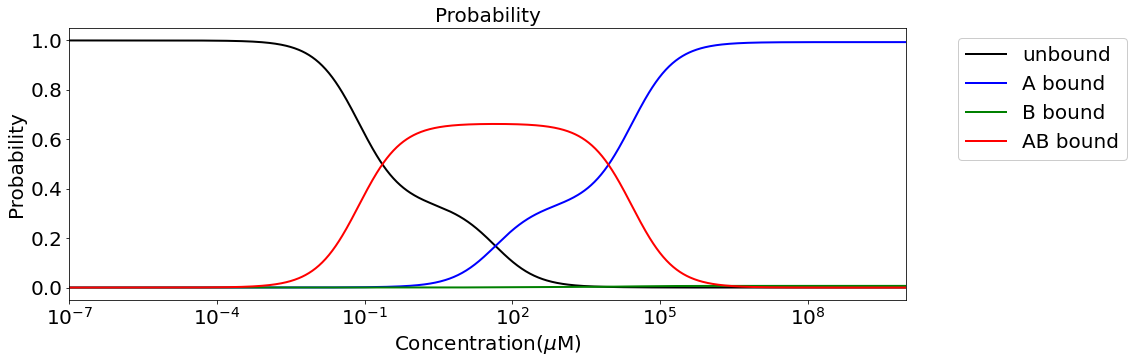

In [ ]:
#@title Make plot
x = c*10**6  #
colors = ['black','red','blue','green']
fig = plt.figure(figsize=[15, 5])

plt.semilogx(x, p_unbound, color = colors[0], label='unbound', lw=2)
if  np.all(mu_A == mu_B):
    plt.semilogx(x, p_Abound+p_Bbound, color = colors[2], label='A/B bound',lw=2)
else:
    plt.semilogx(x, p_Abound, color = colors[2], label='A bound',lw=2)
    plt.semilogx(x, p_Bbound, color = colors[3], label='B bound',lw=2)
plt.semilogx(x, p_ABbound, color = colors[1], label='AB bound', lw=2)
plt.ylim(-0.05,1.05)
plt.xlim(x[0],x[-1])
plt.ylabel('Probability', size=20)
plt.xlabel('Concentration($\mu$M)', size=20)
plt.title('Probability', size=20)
plt.tick_params(labelsize=20)
plt.legend(loc='upper left',framealpha=1, prop = {'size':20},bbox_to_anchor=(1.05, 1))
plt.show()

# The apparent binding affinity

In [ ]:
#@title Set values
#@markdown Set number of target sites
num_of_site =  10#@param {type:"integer"}
#@markdown Set domain-site interaction energies $\mu_i^A$ and $\mu_i^B$
A_site_energy = 10 #@param {type:"number"}
B_site_energy = 5 #@param {type:"number"}
#@markdown Set inter-domain cooperative energies $\mu^{AB}$ and $\mu^{BA}$
mu_AB = 2 #@param {type:"number"}
mu_BA = 2 #@param {type:"number"}
#@markdown Set the index of calculating concentration range in Molar unit. For example, 'c_lowest_index=-3' and 'c_highest_index=0' means the concentration calculated is from $10^{-3}$ M to $10^0$ M.
c_lowest_index = -10 #@param {type:"number"}
c_highest_index = -2 #@param {type:"number"}


num_of_points = 1000
mu_A = np.ones(num_of_site) * A_site_energy  # domain-site interaction energy between A domain and binding site, unit: k_BT
mu_B = np.ones(num_of_site) * B_site_energy  # domain-site interaction energy between B domain and binding site, unit: k_BT
c = 10**np.linspace(c_lowest_index,c_highest_index,num_of_points)  # the concentration range calculated

In [ ]:
#@title Calculate the apparent affinity when the ligand has only A domain, only B domain or AB domains.

[e_A,e_B,e_AB,e_BA] = e_func(mu_A,mu_B,mu_AB,mu_BA,c,num_of_site)
p = p_cal_state(mu_A,mu_B,mu_AB,mu_BA,c,0,num_of_site)
p_A = np.zeros(len(c))
p_B = np.zeros(len(c))
p_AB = np.zeros(len(c))
for n in range(len(c)):
    p_A[n] = 1 - single_mul_list(e_A[:,n])
    p_B[n] = 1 - single_mul_list(e_B[:,n])
    p_AB[n] = 1 - mul_list(p[:,n])
index_A = [ m for m, i in enumerate(p_A) if i>0.5 ][0]
index_B = [ m for m, i in enumerate(p_B) if i>0.5 ][0]
index_AB = [ m for m, i in enumerate(p_AB) if i>0.5 ][0]
c_half_A = 0.5*(sum(c[index_A-1:index_A+1])) * 10 ** 6
c_half_B = 0.5*(sum(c[index_B-1:index_B+1])) * 10 ** 6
c_half_AB = 0.5*(sum(c[index_AB-1:index_AB+1])) * 10 ** 6

print("The apparent affinity of A-ligand is: {:3.3} \u03BCM".format(c_half_A))
print("The apparent affinity of B-ligand is: {:3.3} \u03BCM".format(c_half_B))
print("The apparent affinity of AB-ligand is: {:3.3} \u03BCM".format(c_half_AB))

The apparent affinity of A-ligand is: 3.25 μM
The apparent affinity of B-ligand is: 4.82e+02 μM
The apparent affinity of AB-ligand is: 0.000857 μM


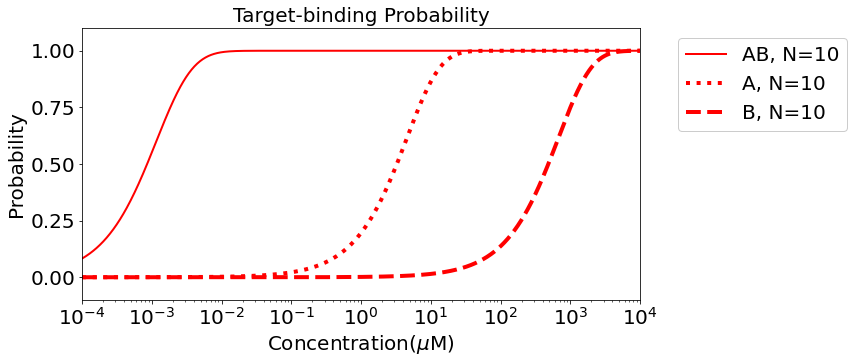

In [ ]:
#@title Make plot
x = c*10**6
fig = plt.figure(figsize=[10, 5])

plt.semilogx(x, p_AB, 'red', linestyle='solid', label='AB, N=%.d'%num_of_site, lw=2)
plt.semilogx(x, p_A, 'red', linestyle='dotted', label='A, N=%.d'%num_of_site, lw=4)
plt.semilogx(x, p_B, 'red', linestyle='dashed', label='B, N=%.d'%num_of_site, lw=4)
plt.ylim(-0.1,1.1)
plt.xlim(x[0],x[-1])
plt.ylabel('Probability', size=20)
plt.xlabel('Concentration($\mu$M)', size=20)
plt.title('Target-binding Probability', size=20)
plt.tick_params(labelsize=20)
plt.legend(loc='upper left',framealpha=1, prop = {'size':20},bbox_to_anchor=(1.05, 1))
plt.show()

# The apparent binding specificity

The working concentration range is: 1.9267247677577812e-05 to 0.055242985057496065 uM
The specificity range is: 10.14297448602567 to 13221.464309730512


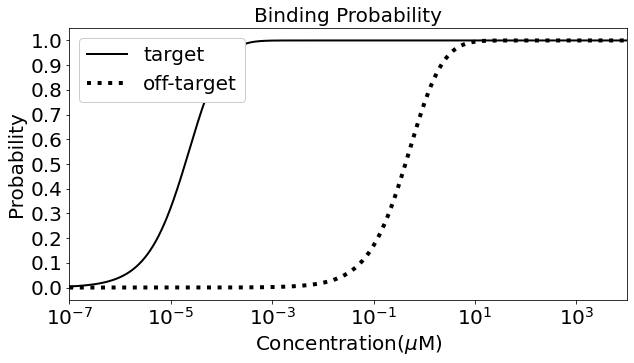

In [ ]:
#@title Set values
#@markdown Set number of target sites
num_of_site = 4 #@param {type:"integer"}
#@markdown Set domain-site interaction energies $\mu_s$ and $\mu_n$
specific_energy = 10 #@param {type:"number"}
nonspe_energy = 5 #@param {type:"number"}
#@markdown Set inter-domain cooperative energies $\mu^{AB}$ and $\mu^{BA}$
mu_AB = 2 #@param {type:"number"}
mu_BA = 2 #@param {type:"number"}
#@markdown Set the index of calculating concentration range in Molar unit. For example, 'c_lowest_index=-3' and 'c_highest_index=0' means the concentration calculated is from $10^{-3}$ M to $10^0$ M.
c_lowest_index = -13 #@param {type:"number"}
c_highest_index = -2 #@param {type:"number"}


num_of_points = 1000
c = 10**np.linspace(c_lowest_index,c_highest_index,num_of_points)
mu_s = np.ones(num_of_site) * specific_energy
mu_n = np.ones(num_of_site) * nonspe_energy
p_s_AB = np.zeros(len(c))
p_n_AB = np.zeros(len(c))


In [ ]:
#@title Calculate working concentration range and the apparent specificity of two-domain ligands.
p_s = p_cal_state(mu_s,mu_s,mu_AB,mu_BA,c,0,num_of_site)
p_n = p_cal_state(mu_n,mu_n,mu_AB,mu_BA,c,0,num_of_site)

for n in range(len(c)):
    p_n_AB[n] = 1 - mul_list(p_n[:,n])
    p_s_AB[n] = 1 - mul_list(p_s[:,n])
s_AB = p_s_AB / p_n_AB
index_s = [ m for m, i in enumerate(p_s_AB) if i>0.5 ][0]
index_n = [ m for m, i in enumerate(p_n_AB) if i>0.1 ][0]
c_s_AB = 0.5*(sum(c[index_s-1:index_s+1])) * 10 ** 6
c_n_AB = 0.5*(sum(c[index_n-1:index_n+1])) * 10 ** 6

print("The working concentration range is: {:3.3} to {:3.3} \u03BCM".format(c_s_AB, c_n_AB))
print("The specificity range is: {:3.3} to {:3.3}".format(min(s_AB[index_s:index_n]), max(s_AB[index_s:index_n])))


The working concentration range is: 1.93e-05 to 0.0552 μM
The specificity range is: 10.1 to 1.32e+04


In [ ]:
#@title Make plot
x = c*10**6
fig = plt.figure(figsize=[10, 5])

plt.semilogx(x, p_s_AB, 'black', linestyle='solid', label='target', lw=2)
plt.semilogx(x, p_n_AB, 'black', linestyle='dotted', label='off-target', lw=4)
plt.yticks(np.arange(0,1.1,step=0.1))
plt.ylim(-0.05,1.05)
plt.xlim(x[0],x[-1])
plt.ylabel('Probability', size=20)
plt.xlabel('Concentration($\mu$M)', size=20)
plt.title('Binding Probability', size=20)
plt.tick_params(labelsize=20)
plt.legend(loc='upper left',framealpha=1, prop = {'size':20})
plt.show()

The working concentration range is: 8.58 to 1.8e+02 μM
The specificity range is: 10.1 to 98.0


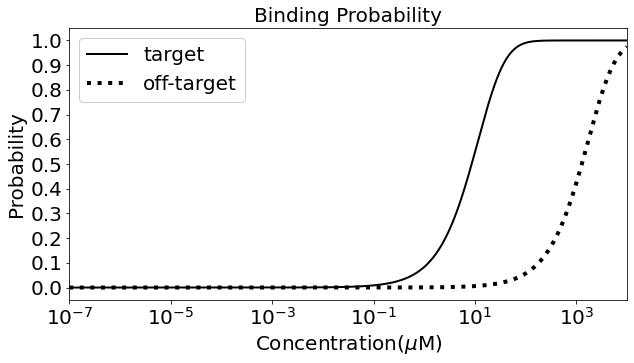

In [ ]:
#@title The result of single-domain ligand for comparison
p_s_A = np.zeros(len(c))
p_n_A = np.zeros(len(c))
e_s = np.exp(specific_energy) * c
e_n = np.exp(nonspe_energy) * c
for n in range(len(c)):
    p_n_A[n] = 1-(1/(1+e_n[n])**num_of_site)
    p_s_A[n] = 1-(1/(1+e_s[n])**num_of_site)
s_A = p_s_A / p_n_A
index_s = [ m for m, i in enumerate(p_s_A) if i>0.5 ][0]
index_n = [ m for m, i in enumerate(p_n_A) if i>0.1 ][0]
c_s_A = 0.5*(sum(c[index_s-1:index_s+1])) * 10 ** 6
c_n_A = 0.5*(sum(c[index_n-1:index_n+1])) * 10 ** 6

print("The working concentration range is: {:3.3} to {:3.3} \u03BCM".format(c_s_A, c_n_A))
print("The specificity range is: {:3.3} to {:3.3}".format(min(s_A[index_s:index_n]), max(s_A[index_s:index_n])))

x = c*10**6
fig = plt.figure(figsize=[10, 5])

plt.semilogx(x, p_s_A, 'black', linestyle='solid', label='target', lw=2)
plt.semilogx(x, p_n_A, 'black', linestyle='dotted', label='off-target', lw=4)
plt.yticks(np.arange(0,1.1,step=0.1))
plt.ylim(-0.05,1.05)
plt.xlim(x[0],x[-1])
plt.ylabel('Probability', size=20)
plt.xlabel('Concentration($\mu$M)', size=20)
plt.title('Binding Probability', size=20)
plt.tick_params(labelsize=20)
plt.legend(loc='upper left',framealpha=1, prop = {'size':20})
plt.show()

# Site-specific binding

In [ ]:
#@title Set values
#@markdown Set number of target sites
num_of_site = 10 #@param {type:"integer"}
#@markdown Set domain-site interaction energies $\mu_n^A$ and $\mu_n^B$.
A_site_energy =  10#@param {type:"number"}
B_site_energy = 0 #@param {type:"number"}
#@markdown Set inter-domain cooperative energies $\mu^{AB}$ and $\mu^{BA}$
mu_AB = 0 #@param {type:"number"}
mu_BA = 0 #@param {type:"number"}
#@markdown Set the index of calculating concentration range in Molar unit. For example, 'c_lowest_index=-3' and 'c_highest_index=0' means the concentration calculated is from $10^{-3}$ M to $10^0$ M.
c_lowest_index = -13 #@param {type:"number"}
c_highest_index =  0#@param {type:"number"}

num_of_points = 1000
mu_A = np.ones(num_of_site) * A_site_energy  # domain-site interaction energy between A domain and binding site, unit: k_BT
mu_B = np.ones(num_of_site) * B_site_energy  # domain-site interaction energy between B domain and binding site, unit: k_BT
c = 10**np.linspace(c_lowest_index,c_highest_index,num_of_points)  # the concentration range calculated

In [ ]:
#@markdown Choose the specific domain and specific site index $j$.
domain = "B" #@param ["None", "A", "B"]
site = 5 #@param {type:"integer"}
#@markdown Set the interaction energy between the specific domain and the specific site $\mu_s^A$ or $\mu_s^B$.
changed_energy = 8 #@param {type:"number"}

site = site - 1
if domain=="A":
    mu_A[site] = changed_energy
elif domain=="B":
    mu_B[site] = changed_energy

In [ ]:
#@title Calculate the working concentration range of the ligand with one specific and one nonspecific domain.
p_s = np.zeros(len(c))
p_n = np.zeros(len(c))

p = p_cal_state(mu_A,mu_B,mu_AB,mu_BA,c,0,num_of_site)

for n in range(len(c)):
    p_n[n] = 1 - (np.sum(p[:,n]) - p[site,n]) / (num_of_site - 1)
    p_s[n] = 1 - p[site,n]
index_s = [ m for m, i in enumerate(p_s) if i>0.5 ][0]
index_n = [ m for m, i in enumerate(p_n) if i>0.1 ][0]
c_s = 0.5*(sum(c[index_s-1:index_s+1])) * 10 ** 6
c_n = 0.5*(sum(c[index_n-1:index_n+1])) * 10 ** 6

print("The working concentration range is: {:3.3} to {:3.3} \u03BCM".format(c_s,c_n))


The working concentration range is: 0.0077 to 0.0493 μM


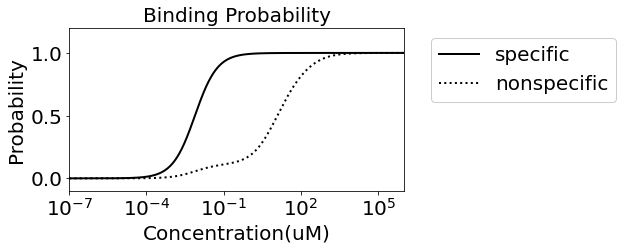

In [ ]:
#@title Make plot of specific and nonspecific binding probabilities under different ligand concentrations.
x = c*10**6
fig = plt.figure(figsize=[6, 3])

plt.semilogx(x, p_s, 'black', linestyle='solid', label='specific', lw=2)
plt.semilogx(x, p_n, 'black', linestyle='dotted', label='nonspecific', lw=2)
plt.ylim(-0.1,1.2)
plt.xlim(x[0],x[-1])
plt.ylabel('Probability', size=20)
plt.xlabel('Concentration(uM)', size=20)
plt.title('Binding Probability', size=20)
plt.tick_params(labelsize=20)
plt.legend(loc='upper left',framealpha=1, prop = {'size':20},bbox_to_anchor=(1.05, 1))
plt.show()

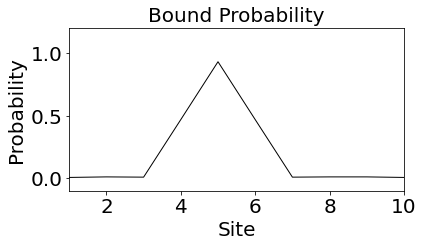

In [ ]:
#@title Make plot of binding probabilities of each site under certain ligand concentration.
#@markdown Set the index of calculating concentration range in Molar unit. For example, 'def_c_index=-3' means the concentration calculated is $10^{-3}$ M.
def_c_index = -7 #@param {type:"number"}
def_c = np.array([10 ** (def_c_index)])
p = p_cal_state(mu_A,mu_B,mu_AB,mu_BA,def_c,0,num_of_site)
fig = plt.figure(figsize=[6, 3])

plt.plot(np.arange(1,num_of_site+1), 1-p[:], 'black', linestyle='solid', lw=1)
plt.ylim(-0.1,1.2)
plt.xlim(1,num_of_site)
plt.ylabel('Probability', size=20)
plt.xlabel('Site', size=20)
plt.title('Bound Probability', size=20)
plt.tick_params(labelsize=20)
plt.show()

The working concentration range is: 3.4e+02 to 1.11e+05 μM


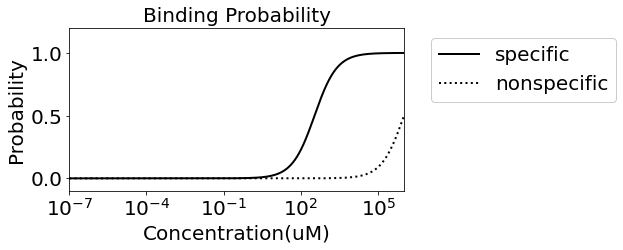

In [ ]:
#@title The result of single-domain ligand with the specific domain for comparison
p_s = np.zeros(len(c))
p_n = np.zeros(len(c))
p = np.zeros((num_of_site,len(c)))

if domain=="A":
    mu = mu_A
elif domain=="B":
    mu = mu_B
for j in range(len(c)):
    for n in range(num_of_site):
        p[n][j] = 1 / (1 + np.exp(mu[n]) * c[j])
    p_n[j] = 1 - (np.sum(p[:,j]) - p[site][j]) / (num_of_site - 1)
    p_s[j] = 1 - p[site,j]
index_s = [ m for m, i in enumerate(p_s) if i>0.5 ][0]
index_n = [ m for m, i in enumerate(p_n) if i>0.1 ][0]
c_s = 0.5*(sum(c[index_s-1:index_s+1])) * 10 ** 6
c_n = 0.5*(sum(c[index_n-1:index_n+1])) * 10 ** 6

print("The working concentration range is: {:3.3} to {:3.3} \u03BCM".format(c_s, c_n))

x = c*10**6
fig = plt.figure(figsize=[6, 3])

plt.semilogx(x, p_s, 'black', linestyle='solid', label='specific', lw=2)
plt.semilogx(x, p_n, 'black', linestyle='dotted', label='nonspecific', lw=2)
plt.ylim(-0.1,1.2)
plt.xlim(x[0],x[-1])
plt.ylabel('Probability', size=20)
plt.xlabel('Concentration(uM)', size=20)
plt.title('Binding Probability', size=20)
plt.tick_params(labelsize=20)
plt.legend(loc='upper left',framealpha=1, prop = {'size':20},bbox_to_anchor=(1.05, 1))
plt.show()


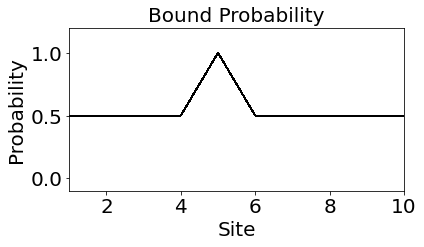

In [ ]:
#@title Make plot of single-domain ligand binding probabilities of each site under certain ligand concentration.
#@markdown Set the index of calculating concentration range in Molar unit. For example, 'def_c_index=-3' means the concentration calculated is $10^{-3}$ M.
def_c_index = 0 #@param {type:"number"}
def_c = np.array([10 ** (def_c_index)])
for n in range(num_of_site):
    p[n] = 1 / (1 + np.exp(mu[n]) * def_c[0])
fig = plt.figure(figsize=[6, 3])

plt.plot(np.arange(1,num_of_site+1), 1-p[:], 'black', linestyle='solid', lw=1)
plt.ylim(-0.1,1.2)
plt.xlim(1,num_of_site)
plt.ylabel('Probability', size=20)
plt.xlabel('Site', size=20)
plt.title('Bound Probability', size=20)
plt.tick_params(labelsize=20)
plt.show()